# Demo of endpoint donor_distribution (part 2)

Documentation: http://geco.deib.polimi.it/popstudy/api/ui/#/default/server.api.donor_distribution

Requirements to run this demo: https://github.com/tomalf2/data_summarization_1KGP/blob/master/demo/README_requirements.txt

The goal of this demo is to show you an example of filter on regions. By using the appropriate keyword inside the 'having_variants' block, we can express many different types of region constraints: 'with' indicates the variants to be present in the individuals; 'on_same_chrom_copy' and 'on_diff_chrom_copy' indicate the variants to be present respectively on the same/different chromatids inside each individual; 'in' allows to specify a genomic region or a gene where at least one variant must occur. Except for the different request parameter, this demo proceeds in the same way as shown in [donor_distribution_part_1](https://github.com/tomalf2/data_summarization_1KGP/blob/master/demo/donor_distribution_part_1.ipynb) - or as Colaboratory notebook [here](https://colab.research.google.com/drive/1Mutc71GeMPNtLRO3HlUyccY1-X4q7tel) - to show how you can use the API to find characteristics that are peculiar to a specific population.


We prepare the request parameters selecting the healthy individuals located in the South Asian continent, but this time we also request they to have the variants - as a tuple chromosome-start-reference-alternative allele -:

1-13271-G-C and 

1-15272-A-T

aligned on assembly hg19. 

As in donor_distribution_part_1, for those individuals we want to know their gender and their country of origin (population).

In [1]:
import json
param = {
    'distribute_by': [
        'gender',
        'population'
    ],
    'having_meta': {
        'health_status': "true",
        'super_population': ['SAS'],
        'assembly': 'hg19'
    },
    'having_variants': {
        'with': [{'chrom': 1, 'start': 13271, 'ref': 'G', 'alt': 'C'}, {'chrom': 1, 'start': 15272, 'ref': 'A', 'alt': 'T'}]
    }
}
body = json.dumps(param)
print(body)

{"distribute_by": ["gender", "population"], "meta": {"health_status": "true", "super_population": ["SAS"], "assembly": "hg19"}, "variants": {"with": [{"chrom": 1, "start": 13271, "ref": "G", "alt": "C"}, {"chrom": 1, "start": 15272, "ref": "A", "alt": "T"}]}}


POST the endpoint \donor_distribution with the prepared JSON parameter

In [2]:
import requests

r = requests.post('http://geco.deib.polimi.it/popstudy/api/donor_distribution', json=param)
print(' response status code: {}'.format(r.status_code))
response_body = r.json()

response status code: 200


# Inspect response data:
It's a data cube with the numerosity of the individuals grouped on the free-dimensions: gender, dna_source and population (to be intended as country of origin)

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
columns = response_body['columns']
rows = response_body['rows']
df = pd.DataFrame.from_records(rows, columns=columns)
df.fillna(value='', inplace=True)    # replaces Nones (== any value) with ''

df0 = df.pivot_table(df, ['POPULATION', 'GENDER'])
df0

DONORS
POPULATION GENDER        
                      131
           female      68
           male        63
BEB                    19
           female       9
           male        10
GIH                    35
           female      16
           male        19
ITU                    23
           female      13
           male        10
PJL                    28
           female      17
           male        11
STU                    26
           female      13
           male        13

Condidering the results obtained from the previous example (demo donor_distribution_part_1), we can determine that the condition imposing the presence of the two variants by each individual is not a very common characteristic across the individuals of the South Asian continent. The population size reduced to 131 indeed, almost 1/5 of the previous population.  

Now, if we wanted to see how the individuals are distributed by country this time, we could do like so:

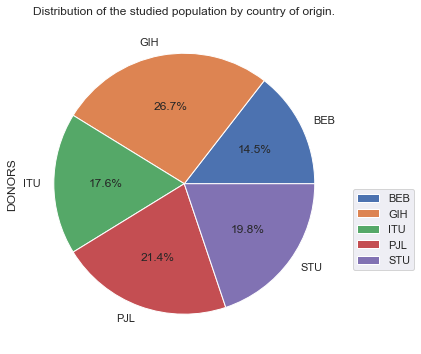

In [4]:
import seaborn as sns
# use Seaborn styles
sns.set()
df10 = df.drop(df.query('GENDER != "" | POPULATION == ""').index)  # remove rows where gender is not empty
df10.drop(['GENDER'], inplace=True, axis=1) # remove gender column
df10.pivot_table(df10, index=['POPULATION']).plot(
    kind='pie', 
    y='DONORS',
    figsize=(8, 6),
    autopct='%1.1f%%')
plt.title('Distribution of the studied population by country of origin.')
plt.legend(bbox_to_anchor=(1.0, 0.5))
plt.show()

From the above plot, we can notice that the introduction of the region constraints changed also the composition of the data. Now the individuals are no more equally distributed, instead we've an over-representation of individuals of the GIH population, while the donors from BEB slightly decreased.

Let's see how this new condition reflects in the gender of the individuals:

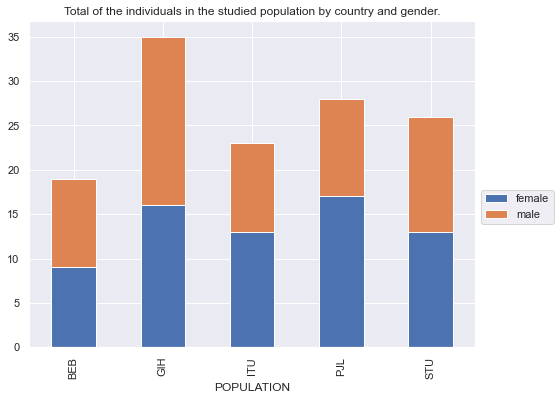

In [5]:
# prepare data frame
df2 = df.drop(df.query('GENDER == "" | POPULATION == "" ').index)    

df2_pivot = df2.pivot(index='POPULATION', columns='GENDER', values='DONORS') # creates a df with populations as index of rows, genders as columns, n° samples as cell values
df2_pivot.plot( # automatically uses the values of index as x-axis and stacks the values of columns
    kind='bar',
    stacked=True,
    figsize=(8, 6),
)
plt.title('Total of the individuals in the studied population by country and gender.')    
plt.legend(bbox_to_anchor=(1.0, 0.5))
plt.show()

Comparing these plots with the ones from the notebook [donor_distribution_part_1](https://github.com/tomalf2/data_summarization_1KGP/blob/master/demo/donor_distribution_part_1.ipynb) (or Colab version: [donor_distribution_part_1](https://colab.research.google.com/drive/1Mutc71GeMPNtLRO3HlUyccY1-X4q7tel)), we can conclude that the two varaints 1:13271-C and 1:15272-T are more frequent in the GIH (Gujarati Indian in Houston) population than in others poulation of the South Asian continent, particularly in males.